In [51]:
import os
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
base_folder = "../outputs/TE_cnig_provincias/"
cases_fname = os.path.join(base_folder, "cases_pop_ds.nc")
risk_ij_fname = os.path.join(base_folder, "risk_ds.nc")

cases_ds = xr.load_dataset(cases_fname)
risk_ds = xr.load_dataset(risk_ij_fname)

risk_ij = risk_ds['risk_ij']
trips_ij = risk_ds['trips_ij']

risk_ij_dt = risk_ij.diff('date')
trips_ij_dt = trips_ij.diff('date')

cases_by_100k = cases_ds['new_cases_by_100k']
cases_by_100k_dt = cases_by_100k.diff('date')

dates = risk_ij_dt.coords['date'].values

df_pro = pd.read_parquet('../data/cnig_provincias.parquet').sort_index()
df_pro = df_pro.drop(['51', '52'])

In [69]:
X_ij = xr.load_dataset(os.path.join(base_folder, "X.nc"))['risk_ij']
Y_j  = xr.load_dataset(os.path.join(base_folder, "Y.nc"))['new_cases_by_100k']

In [73]:
TE_ds = xr.load_dataset('../outputs/TE_cnig_provincias/run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij/TE.nc')
TE_ds

<xarray.Dataset> Size: 16MB
Dimensions:      (date: 407, source: 50, target: 50)
Coordinates:
  * date         (date) datetime64[ns] 3kB 2020-03-15 2020-03-16 ... 2021-04-25
  * source       (source) object 400B '01' '02' '03' '04' ... '48' '49' '50'
  * target       (target) object 400B '01' '02' '03' '04' ... '48' '49' '50'
Data variables:
    TE_dynamic   (source, target, date) float64 8MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ETE_dynamic  (source, target, date) float64 8MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TE_global    (source, target) float64 20kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ETE_global   (source, target) float64 20kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

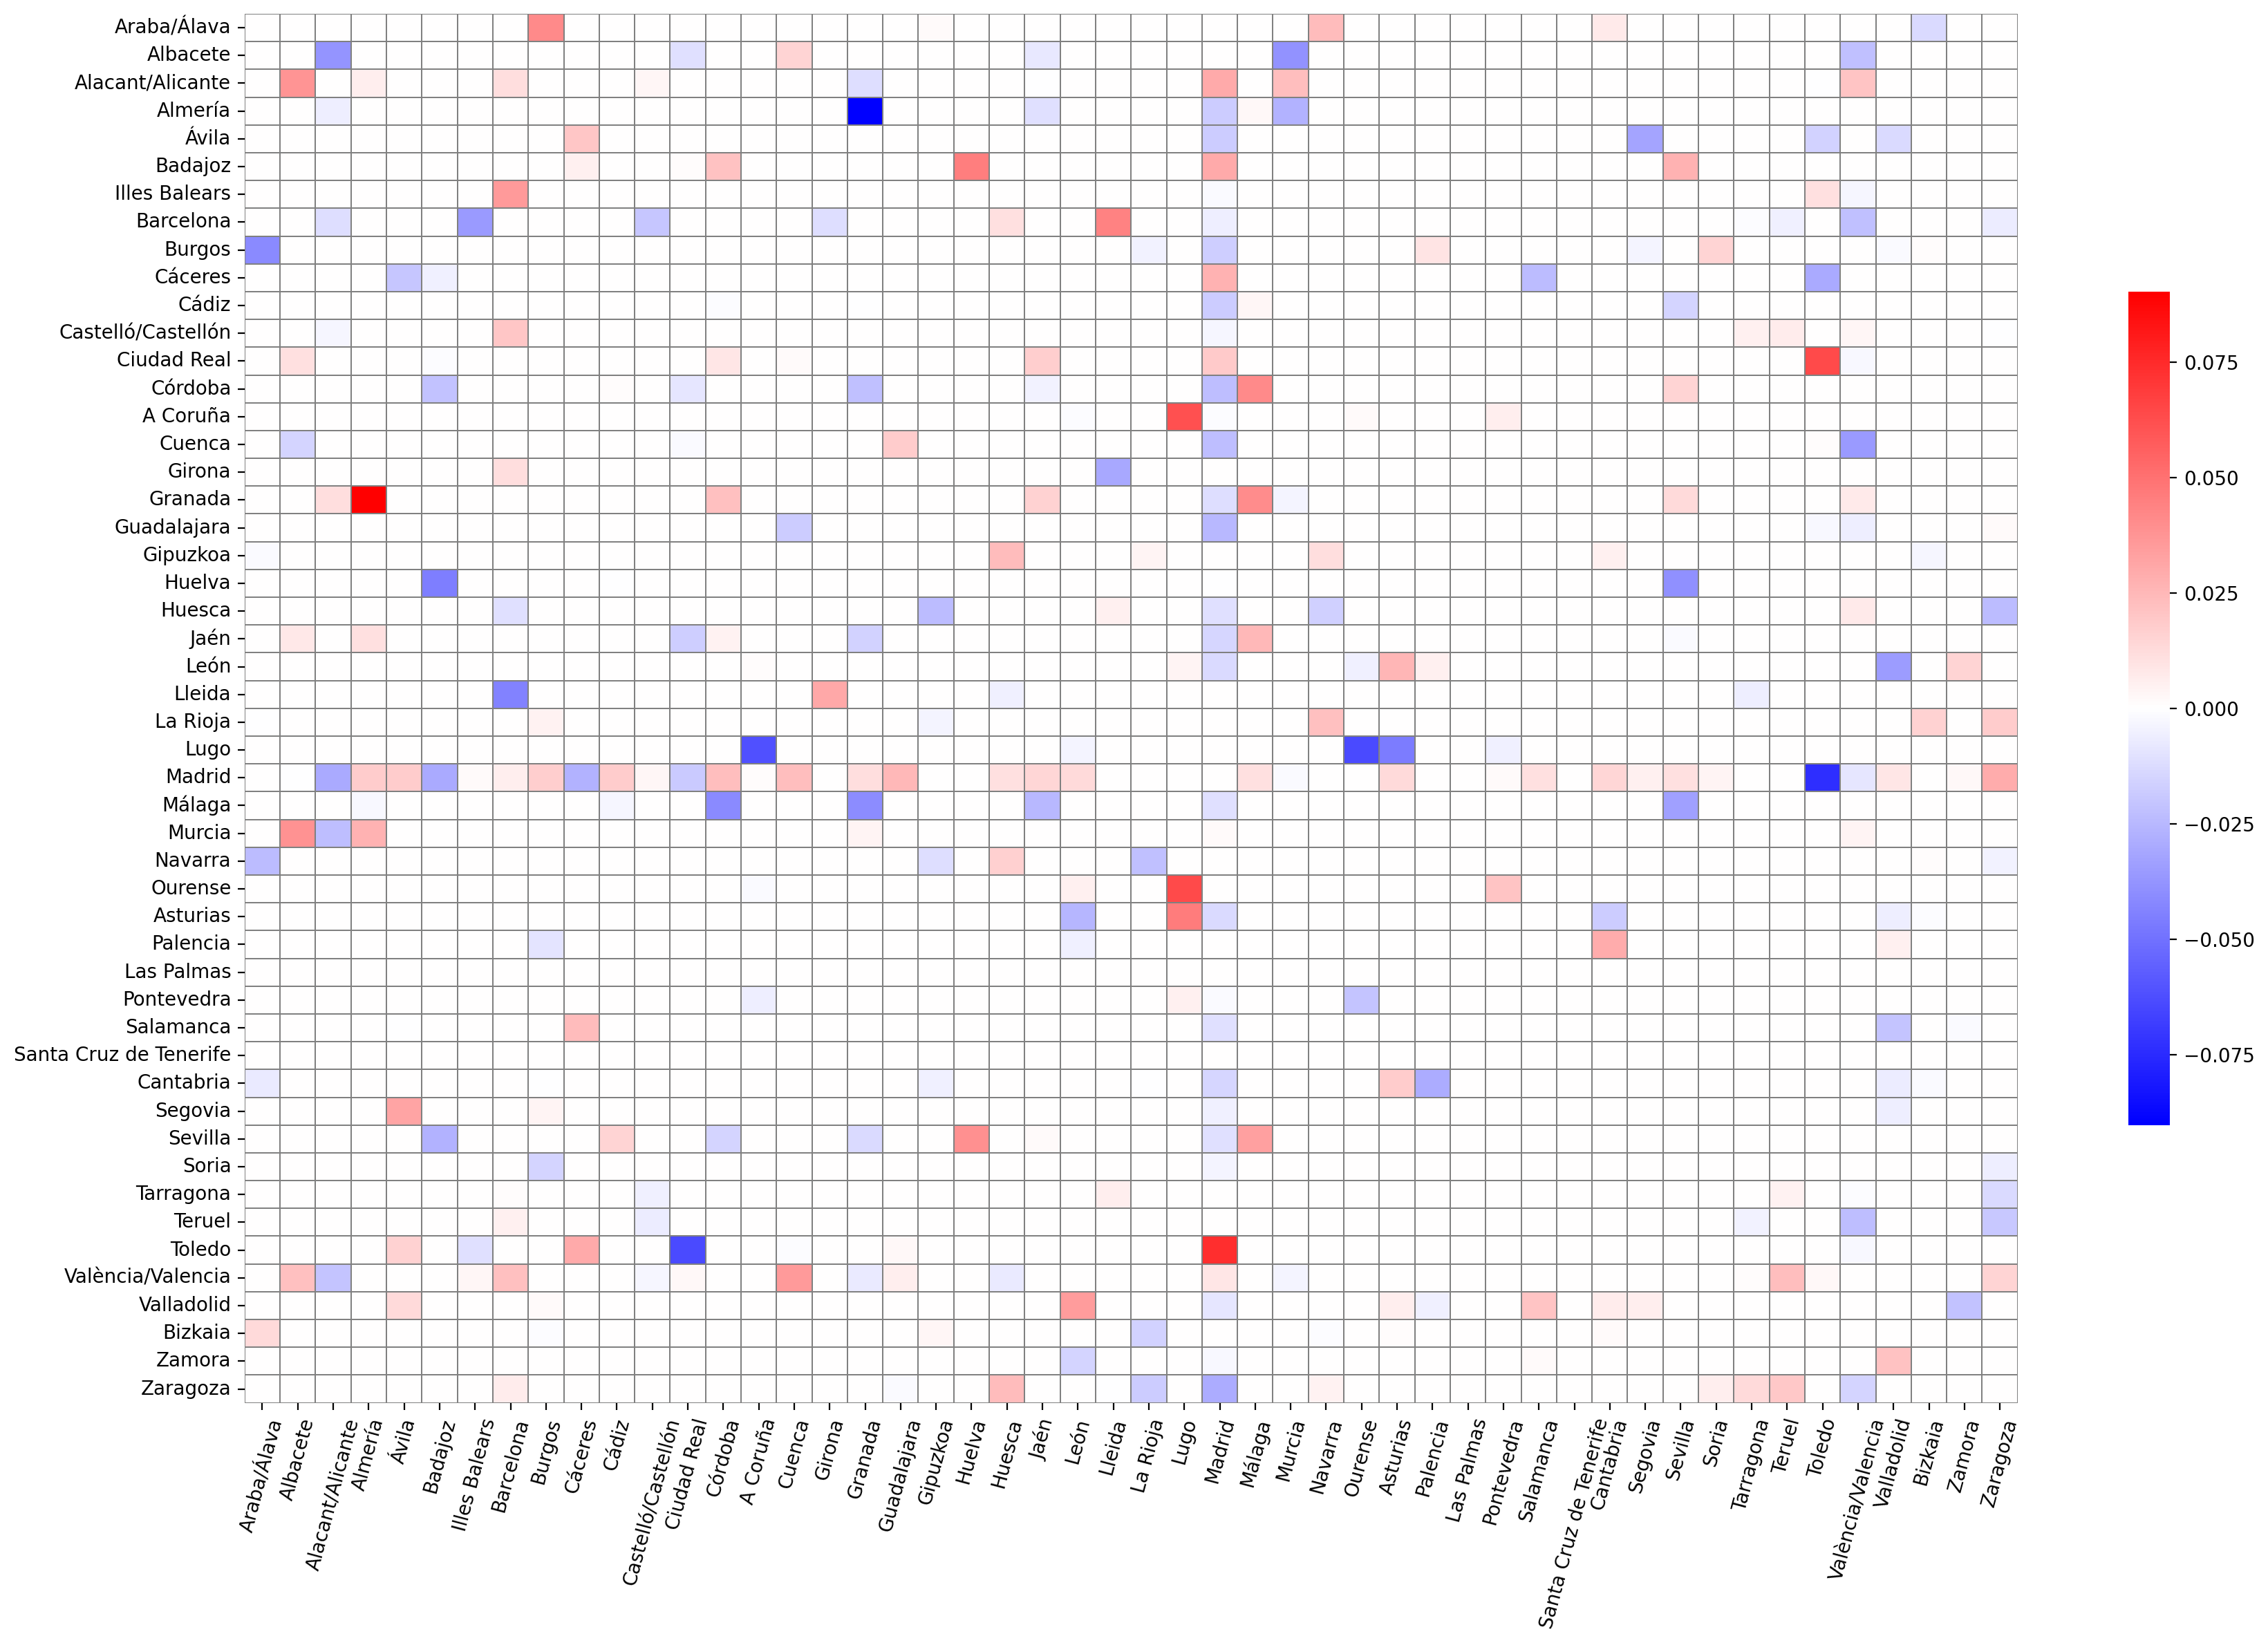

In [54]:
gTE =  TE_ds['TE_global'].values
gETE = TE_ds['ETE_global'].values

DI_global = pd.DataFrame(data=(gTE-gTE.T), columns=df_pro['pro_name'].values, index=df_pro['pro_name'].values)
eff_DI_global = pd.DataFrame(data=(gETE-gETE.T), columns=df_pro['pro_name'], index=df_pro['pro_name'])

fig, ax = plt.subplots(1, 1, figsize=(18,12), sharex=True, dpi=200)

g = sns.heatmap(DI_global, cmap='bwr', linewidths=.01, linecolor='grey', cbar_kws={'shrink': 0.6}, ax=ax)
_ = g.set_yticklabels(g.get_yticklabels(), rotation = 0)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 75)

fig.tight_layout()

In [66]:
X_ij


<xarray.Dataset> Size: 4MB
Dimensions:  (date: 448, source: 50, target: 50)
Coordinates:
  * date     (date) datetime64[ns] 4kB 2020-02-16 2020-02-17 ... 2021-05-08
  * source   (source) object 400B '01' '02' '03' '04' ... '47' '48' '49' '50'
  * target   (target) object 400B '01' '02' '03' '04' ... '47' '48' '49' '50'
Data variables:
    risk_ij  (source, target, date) int32 4MB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1

407 407


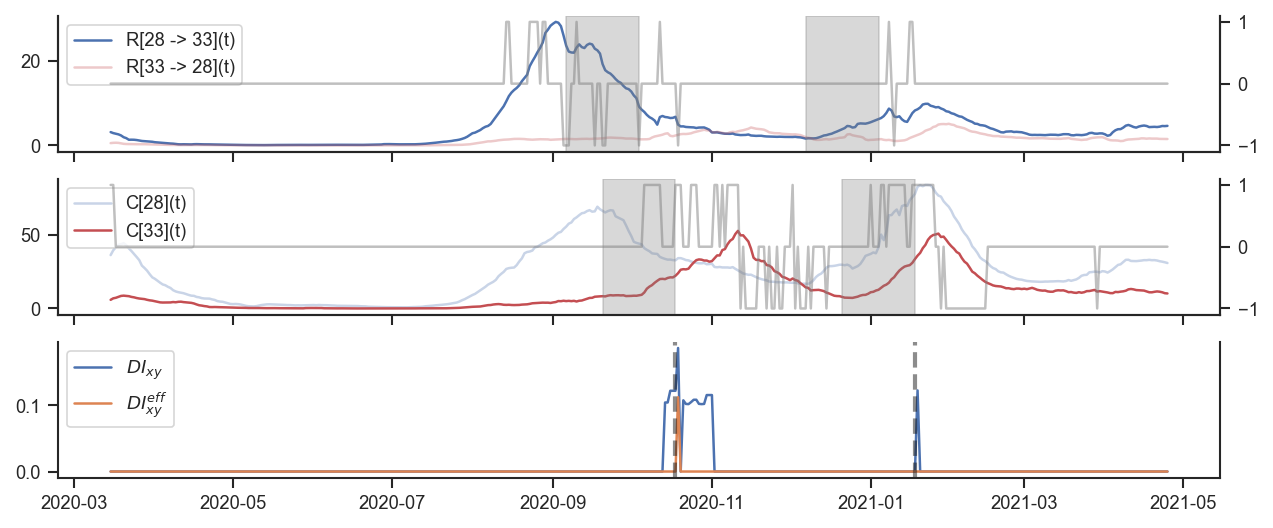

407 407


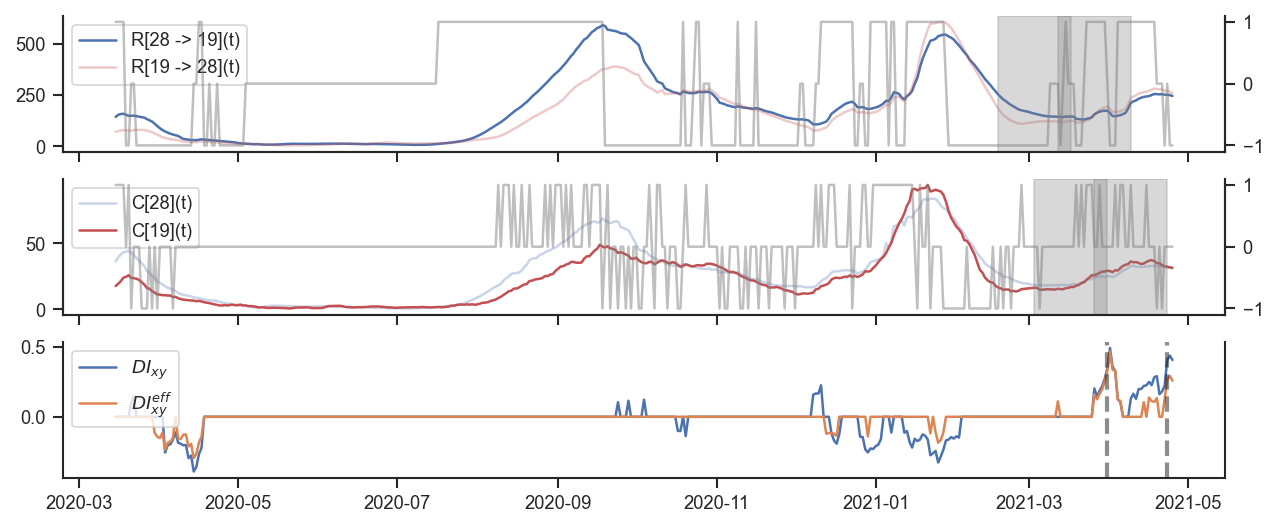

407 407


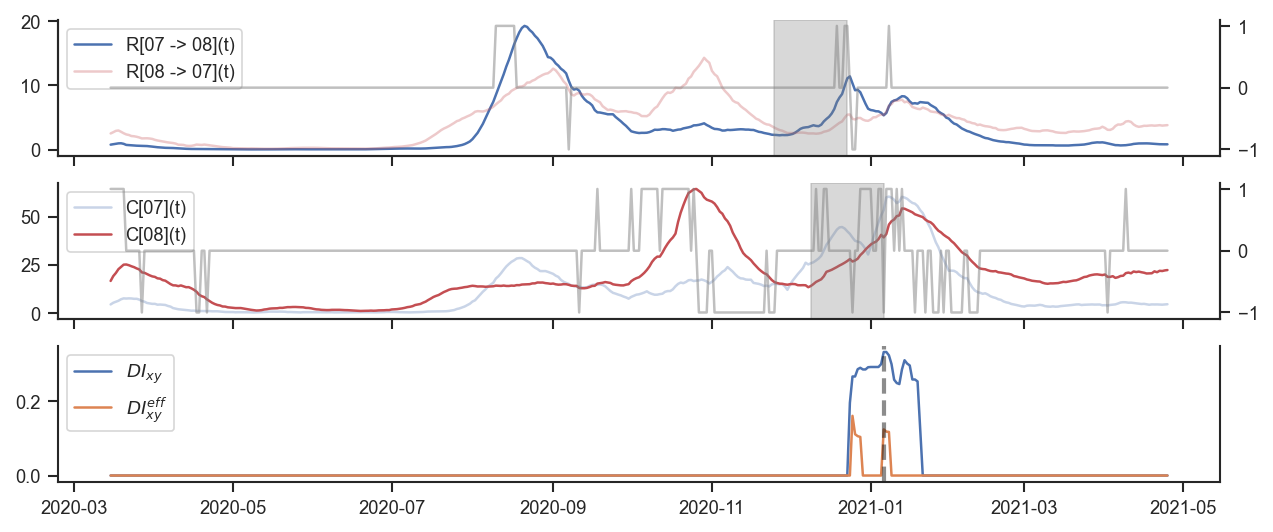

407 407


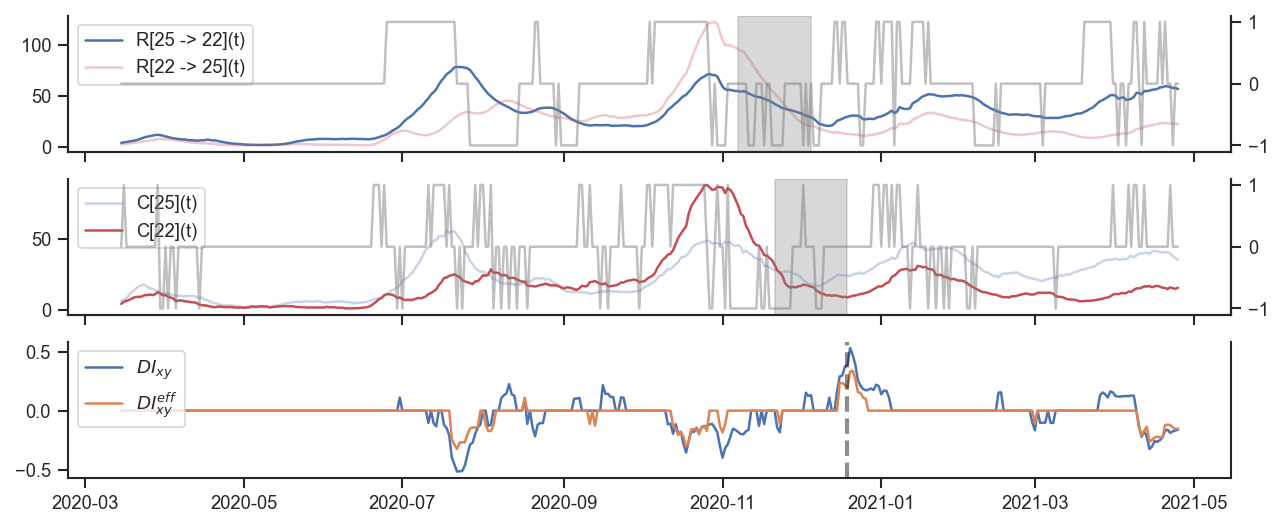

In [77]:
sns.set_theme('paper')
sns.set_style("ticks")

thr = 0.1
use_ETE = False
top = 2
offset = 45
omega = 28
delta = 14
TE  = TE_ds['TE_dynamic']
ETE = TE_ds['ETE_dynamic']

study_cases = [("28", "33"), ("28", "19"), ("07", "08"), ("25", "22")]
for x,y in study_cases:    
    TE_xy = TE.loc[x,y,:]
    TE_yx = TE.loc[y,x,:]

    ETE_xy = ETE.loc[x,y,:]
    ETE_yx = ETE.loc[y,x,:]
    
    start = omega
    TE_dates = dates[start:]
    end = min(len(TE_dates), TE_xy.shape[0])
    TE_dates = TE_dates[:end]
    
    DIxy = TE_xy - TE_yx
    DIxy[np.abs(DIxy) < thr] = 0
    
    EDIxy = ETE_xy - ETE_yx
    EDIxy[np.abs(EDIxy) < thr] = 0

    print(len(TE_dates), len(DIxy))

    if DIxy[offset:].max() < thr:
        continue

    top_k_TE_indices = np.argsort(DIxy[offset:])[-top:][::-1] + offset -1
    top_k_TE_dates = TE_dates[top_k_TE_indices]
    
    top_k_ETE_indices = np.argsort(EDIxy[offset:])[-top:][::-1] + offset -1
    top_k_ETE_dates = TE_dates[top_k_ETE_indices]
    
    top_k_indices = top_k_TE_indices
    top_k_dates = top_k_TE_dates
    
    if np.abs(top_k_indices[0] - top_k_indices[1]) < omega/2.:
        top_k_indices = top_k_indices[:1]
        top_k_dates = top_k_dates[:1]
    
    fig, axes = plt.subplots(3, 1, figsize=(10,4), sharex=True, dpi=150)
    ax = axes[0]
    ax.plot(risk_ij.loc[x, y, TE_dates].to_pandas(), label=rf"R[{x} -> {y}](t)")
    ax.plot(risk_ij.loc[y, x, TE_dates].to_pandas(), label=rf"R[{y} -> {x}](t)", c='r', alpha=0.3)
    ax.legend(loc=2)
    ax = ax.twinx()
    ax.set_yticks([-1,0,1])
    ax.plot(X_ij.loc[x, y, TE_dates].to_pandas()-1, c='grey', alpha=0.5)
    for index_date in top_k_indices:
        start = TE_dates[index_date-omega-delta]
        end = TE_dates[index_date-delta]
        ax.axvspan(start, end, color='grey', alpha=0.3)
    
    ax = axes[1]
    ax.plot(cases_by_100k.loc[x, TE_dates].to_pandas(), label=rf"C[{x}](t)", alpha=0.3)
    ax.plot(cases_by_100k.loc[y, TE_dates].to_pandas(), c='r', label=rf"C[{y}](t)")
    ax.legend(loc=2)
    ax = ax.twinx()
    ax.set_yticks([-1,0,1])
    ax.plot(Y_j.loc[y, TE_dates].to_pandas()-1, c='grey', alpha=0.5)
    for index_date in top_k_indices:
        start = TE_dates[index_date-omega]
        end = TE_dates[index_date]
        ax.axvspan(start, end, color='grey', alpha=0.3)
    
    axes[2].plot(TE_dates, DIxy, label=r"$DI_{xy}$")
    axes[2].plot(TE_dates, EDIxy, label=r"$DI^{eff}_{xy}$")
    for index_date in top_k_indices:
        axes[2].axvline(TE_dates[index_date], c='k', ls='--', lw=2, alpha=0.5)
    axes[2].legend(loc=2)
   
    sns.despine(left=False, right=False)
    plt.show()

In [44]:
TE_ds['TE_global'].max()

<xarray.DataArray 'TE_global' ()> Size: 8B
np.float64(0.0)